In [3]:
%matplotlib inline
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import boost_histogram as bh
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from lmfit.models import *
from lmfit import Model, Parameters

In [8]:
# read in reconstructed data
rec = pd.read_csv("yields.csv", index_col=False )
rec = rec[(rec.w > 0)]
rec['cos_theta'] = np.cos(rec.pip_theta).astype(np.float32)

rec.head()

,electron_sector,w,q2,pip_theta,pip_phi,mm2,cos_theta
0,6,2.873988,1.716060,0.189954,1.543111,0.876241,0.982013
1,3,2.418472,2.508214,1.597553,5.685010,3.230610,-0.026754
2,3,3.209562,1.995455,2.076396,2.839622,8.461404,-0.484332
3,5,2.840966,2.174617,0.659998,4.884259,2.774773,0.789994
4,3,3.967216,1.983728,2.313542,3.117807,8.241228,-0.676313


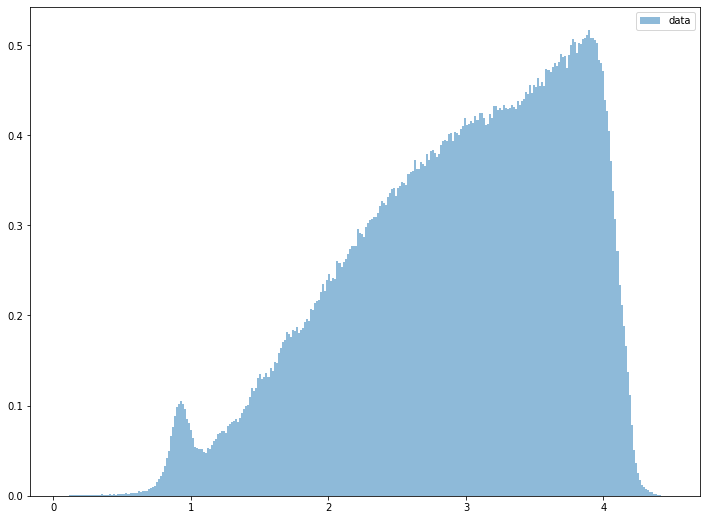

In [9]:
# plot W histogram

# Make a figure and axes to plot on
fig, ax = plt.subplots(figsize=(12,9))

# Plot hist on axes
ax.hist(rec.w, bins=300, alpha=0.5, label='data', density=True, )

# put legend on axes
ax.legend()

# Show figure
fig.show()

In [30]:
# Create function to 
def mm_cut(df):
    NSIGMA = 4
    cut_data = {}
    for sec in range(1,7):
        # Seclect the data for the sector
        data = df[df.electron_sector == sec]
        # Make a figure to plot on
        plt.figure(figsize=(12,9))
        
        # Histogram the data and 
        y,x = np.histogram(data.mm2.to_numpy(), 
                                 bins=100, range=(0.0,1.8), density=True)
        
        # calculate bin centers
        x=(x[1:]+x[:-1])/2

        # Plot points on
        plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)

        # Make a model with a peak
        peak = BreitWignerModel(prefix="peak_")
        pars = peak.make_params()
        # Set some parameters
        pars['peak_center'].set(value=0.9, min=0.8, max=1.0)
        #pars['peak_sigma'].set(value=0.1, min=0.0, max=0.5)
        #pars['peak_amplitude'].set(value=0.5)
        
        # Set the background
        background =  PolynomialModel(5, prefix="back_")
        pars.update(background.guess(y, x=x))
        pars['back_c0'].set(value=0,min=0)
        
        # Make full model to fit
        model = peak + background
        
        # Fit our full model
        out = model.fit(y, pars, x=x)
        
        # Make a more fine set of x's to plot with
        xs= np.linspace(0.0, 1.8, 1000)
        
        # Plot our output model withe the new parameter and finer x's
        plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')

        # Get the components of the fit for our finer x's
        comps = out.eval_components(x=xs)
        # Plot just the peak component
        plt.plot(xs, comps['peak_'], 
                 alpha=0.4, label=f"Peak Fit {out.params['peak_center'].value:0.4f}")
        
        # Plot center +- sigma where we will cut later
        #plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
        #plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
        # Put on labels and show the plot
        plt.legend()
        plt.show()
        
        # Save cut data to our
        cut_data[sec] = (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
                     out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        

    return cut_data

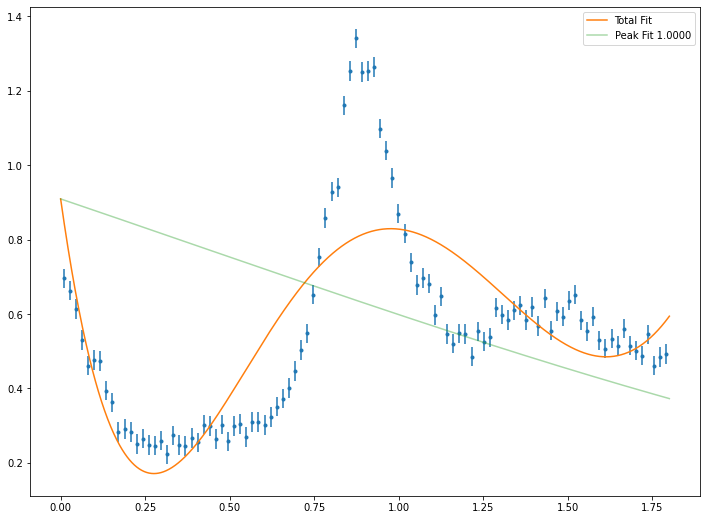

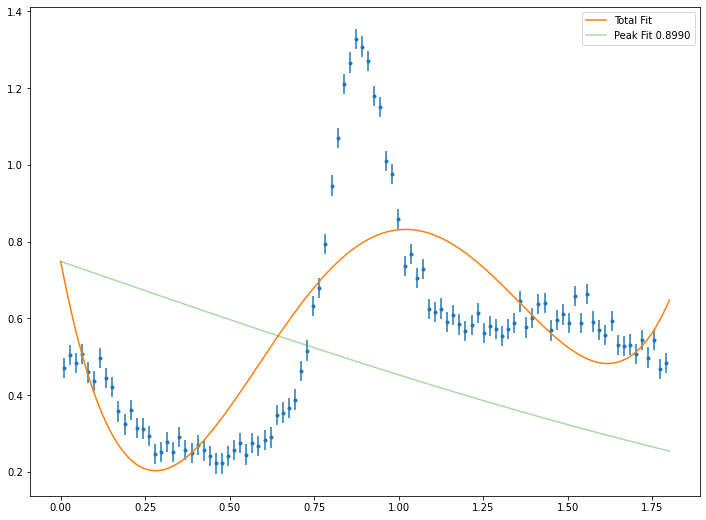

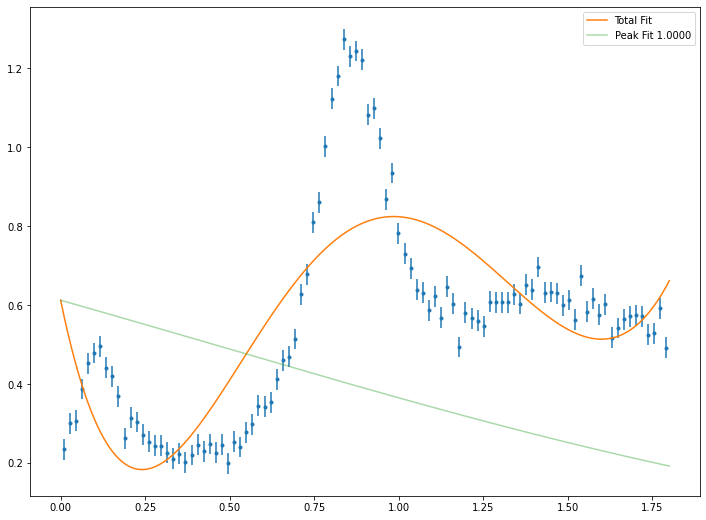

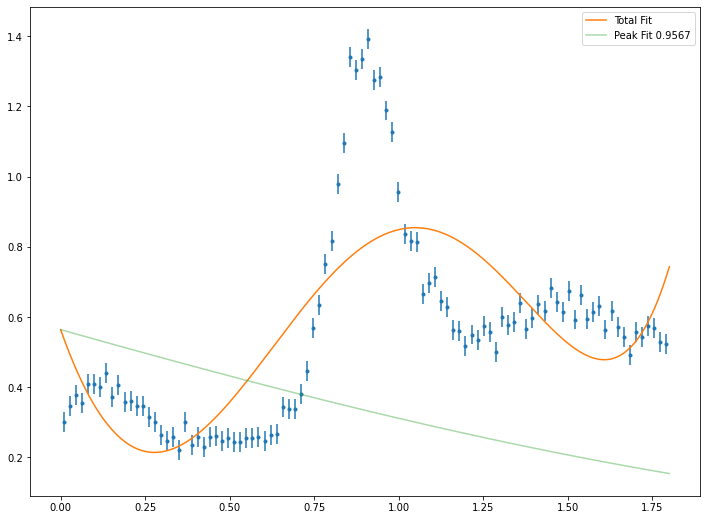

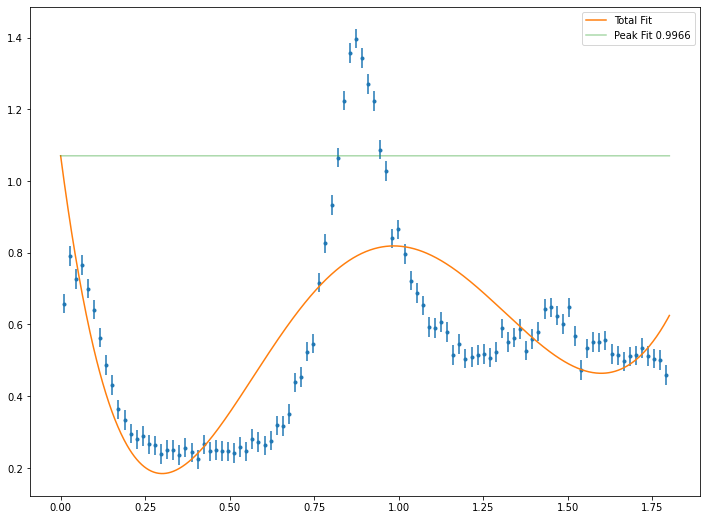

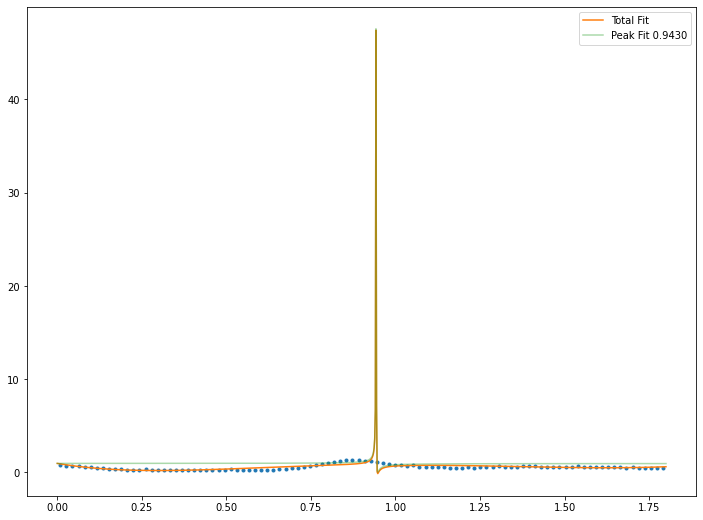

In [31]:
sector_cuts = mm_cut(rec)

In [ ]:
# https://lmfit.github.io/lmfit-py/builtin_models.html#example-3-fitting-multiple-peaks-and-using-prefixes
dat = np.loadtxt('Gauss3.dat')
x = dat[:, 1]
y = dat[:, 0]

exp_mod = ExponentialModel(prefix='exp_')
pars = exp_mod.guess(y, x=x)

gauss1 = GaussianModel(prefix='g1_')
pars.update(gauss1.make_params())

pars['g1_center'].set(value=105, min=75, max=125)
pars['g1_sigma'].set(value=15, min=3)
pars['g1_amplitude'].set(value=2000, min=10)

gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

pars['g2_center'].set(value=155, min=125, max=175)
pars['g2_sigma'].set(value=15, min=3)
pars['g2_amplitude'].set(value=2000, min=10)

mod = (gauss1 + gauss2) + exp_mod

init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y, 'b')
axes[0].plot(x, init, 'k--', label='initial fit')
axes[0].plot(x, out.best_fit, 'r-', label='best fit')
axes[0].legend(loc='best')

comps = out.eval_components(x=x)
axes[1].plot(x, y, 'b')
axes[1].plot(x, comps['g1_'], 'g--', label='Gaussian component 1')
axes[1].plot(x, comps['g2_'], 'm--', label='Gaussian component 2')
axes[1].plot(x, comps['exp_'], 'k--', label='Exponential component')
axes[1].legend(loc='best')

plt.show()